# JLMT Python Implementation

**Object**

**Steps**:
1. Audio input
2. ANI

**Environment**:
- Python version: 3.9.0
- Platform: Win(Not support in Mac) 

# 0. Import required packages

In [1]:
import os

os.chdir(os.path.join(r"C:\Users\w1881\Desktop\github\jlmt_python\src\c_code"))
import ipem_auditory_model
os.chdir(r"C:\Users\w1881\Desktop\github\jlmt_python")
print(os.getcwd())

C:\Users\w1881\Desktop\github\jlmt_python


In [5]:
%cd /Users/taowang/Desktop/Github/jlmt_python/

/Users/taowang/Desktop/Github/jlmt_python


/Users/taowang/Desktop/Github/jlmt_python/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install librosa numpy pandas
!pip install matplotlib openpyxl

In [3]:
# Setup and import required packages
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import os
import librosa

import ipem_auditory_model #the c project imported by cython

# 1.2. Audio input and Auditory Nerve Image (ANI)
The current processing method is the same as MATLAB, by resampling to 22,050 Hz, adding 20 ms of silence before and after, calling C code to generate the .ani file, reading the .ani file and the filter frequency, downsampling and plotting.

In [4]:
#Audio input
def load_audio(path, mono=True, normalize=True):
    """
    Load and preprocess an audio file (wav or mp3). 
    
    Parameters: 
        path - Path to audio file 
        sr - Target sampling rate 
        mono - Convert to mono (sum channels) 
        normalize -  Normalize amplitude to [-1, 1].
    
    Returns: 
        y - Audio signal
        sr - Sampling rate
    """
    y, sr = librosa.load(path, mono=mono)
    if normalize:
        y = y / np.max(np.abs(y))
    
    return y.astype(np.float32), sr

In [5]:
#Calculate ANI
def calc_ani(
    in_signal,
    in_sample_freq,
    in_auditory_model_path="./test_sound",
    downsampling_factor=4,
    num_channels=40,
    first_cbu=2.0,
    cbu_step=0.5,
):
    """
    Parameters
        in_signal : np.ndarray
            Input signal
        in_sample_freq : int or float
            Sampling rate (Hz)
        in_auditory_model_path : str
            Directory where auditory model will read/write temp files
        downsampling_factor : int
            Downsampling factor for the ANI (default = 4)
        num_channels : int
            Number of cochlear filter channels
        first_cbu : float
            Starting CBU
        cbu_step : float
            Step size in CBU between channels

    Returns
        out_ani : np.ndarray
            Auditory Nerve Image matrix (num_channels x time_frames)
        out_ani_freq : float
            Sampling rate of ANI (Hz)
        out_filter_freqs : np.ndarray
            Center frequencies (Hz)
    """

    print("Start of calc_ani...")

    # Input validation
    if in_signal.ndim > 1:
        if in_signal.shape[1] == 1:
            in_signal = in_signal[:, 0]
        else:
            raise ValueError("Can only process mono signals.")

    # Resample and pad
    new_sample_freq = 22050
    n_zeros = int(round(0.020 * new_sample_freq))  # 20 ms
    zeros_pad = np.zeros(n_zeros)

    if in_sample_freq != new_sample_freq:
        new_sound = signal.resample_poly(in_signal, new_sample_freq, in_sample_freq)
    else:
        new_sound = in_signal

    new_sound = np.concatenate([zeros_pad, new_sound, zeros_pad])

    # Write temp wav
    input_wav = os.path.join(in_auditory_model_path, "input.wav")
    sf.write(input_wav, new_sound, new_sample_freq, subtype="PCM_16")

    # Call auditory model
    output_ani = os.path.join(in_auditory_model_path, "nerve_image.ani")
    try:
        ipem_auditory_model.process_file(
            "input.wav",
            "nerve_image.ani",
            num_channels=40,
            first_freq=first_cbu,
            freq_dist=cbu_step,
            input_filepath=in_auditory_model_path,
            output_filepath='./',
            sample_frequency=new_sample_freq,
            sound_format='wav'
        )
    except Exception as e:
        raise RuntimeError(f"Error during ipem_process: {e}")

    # Read ANI data
    ani = np.fromfile(output_ani, sep=' ')
    out_ani = ani.reshape((num_channels, -1), order="F")

    # Read filter center frequencies (in kHz)
    filt_file = os.path.join(in_auditory_model_path, "FilterFrequencies.txt")
    if os.path.exists(filt_file):
        out_filter_freqs = np.loadtxt(filt_file) * 1000  # convert to Hz
    else:
        out_filter_freqs = np.linspace(200, 8000, num_channels)  # fallback

    # Remove silence padding
    out_ani = out_ani[:, int(n_zeros / 2):-int(n_zeros / 2)]

    # Downsample if needed
    out_ani_freq = new_sample_freq / 2
    if downsampling_factor != 1:
        out_ani = signal.resample_poly(out_ani.T, 1, downsampling_factor).T
        out_ani_freq /= downsampling_factor


    # Cleanup temp files
    for f in [
        "input.wav", "nerve_image.ani", "FilterFrequencies.txt",
        "decim.dat", "eef.dat", "filters.dat", "lpf.dat",
        "omef.dat", "outfile.dat"
    ]:
        fpath = os.path.join(in_auditory_model_path, f)
        if os.path.exists(fpath):
            os.remove(fpath)

    print("...end of calc_ani.")
    return out_ani, out_ani_freq, out_filter_freqs

In [6]:
#Ploting
def plot_multi_channel(
   data,
   sample_freq=1,
   title='',
   xlabel='',
   ylabel='',
   font_size=None,
   channel_labels=None,
   channel_label_step=1,
   min_y=None,
   max_y=None,
   plot_type=0,
   time_offset=0,
   y_scale_factor=1,
   channels=None,
   one_based_index=True
):
  
   if data is None or len(data) == 0:
       print("None")
       return
  
   n_rows, n_cols = data.shape


   if channel_labels is None:
       channel_labels = [i + 1 for i in range(n_rows)]


   if channels is not None:
       if one_based_index:
           channels = [ch - 1 for ch in channels]
       channels = [ch for ch in channels if 0 <= ch < n_rows]
       if not channels:
           raise ValueError("No valid channel index")


       data = data[channels, :]
       channel_labels = [channel_labels[i] for i in channels]
       n_rows = len(channels)


   if min_y is None:
       min_y = np.min(data)
   if max_y is None:
       max_y = np.max(data)


   time_scale = np.arange(n_cols) / sample_freq + time_offset
   scale = abs(max_y - min_y) / y_scale_factor if y_scale_factor != 0 else 1


   plt.figure(figsize=(10, 6))


   if plot_type in [0, 2]:
       height = 0.9
       offset = height / 2 if plot_type == 2 else 0


       for i in range(n_rows):
           y_vals = i + height * (data[i, :] - min_y) / scale - offset
           plt.plot(time_scale, y_vals, linewidth=0.8)
      
       plt.ylim(1 - offset - 0.1, n_rows + height - offset + 0.1)
       plt.xlim(time_scale[0], time_scale[-1])


   elif plot_type == 1:
       plt.imshow(data, aspect='auto', origin='lower',
                  extent=[time_scale[0], time_scale[-1], 1, n_rows],
                  cmap='gray_r')
   else:
       raise ValueError("Unsupported plot_type (must be 0, 1, or 2)")


   if channel_label_step == -1:
       plt.yticks(np.arange(1, n_rows + 1), channel_labels)
   else:
       ticks = np.arange(0, n_rows, channel_label_step)
       plt.yticks(ticks + 1, [channel_labels[i] for i in ticks])


   plt.xlabel(xlabel)
   plt.ylabel(ylabel)
   plt.title(title)


   if font_size:
       plt.xticks(fontsize=font_size - 2)
       plt.yticks(fontsize=font_size - 2)
       plt.title(title, fontsize=font_size)


   plt.tight_layout()
   plt.show()


In [7]:
# Load audio
y, sr = load_audio("./test_sound/SchumannKurioseGeschichte.wav")
# Calc ANI
ani, ani_freq, freqs = calc_ani(y, sr, "./")
print("ANI shape:", ani.shape)
print("ANI sample rate:", ani_freq)
print("Filter freqs:", freqs[:5], "...")

Start of calc_ani...
...end of calc_ani.
ANI shape: (40, 15165)
ANI sample rate: 2756.25
Filter freqs: [141. 178. 215. 252. 291.] ...


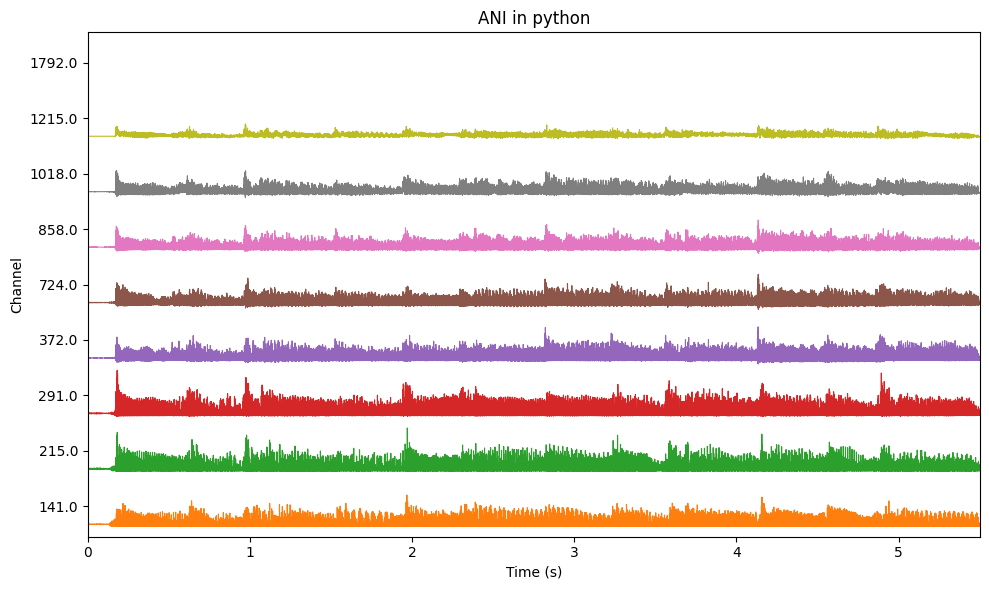

In [8]:
# Polt
plot_multi_channel(
   ani,
   sample_freq=ani_freq,
   title='ANI in python',
   xlabel='Time (s)',
   ylabel='Channel',
   font_size=12,
   channel_labels=freqs,
   channels=[1, 3, 5, 7, 14, 16, 18, 20, 24],#[1, 3, 5, 7, 14, 16, 18, 20, 24],
   plot_type=2
)


# 3. Periodicity Pitch (PP)

In [15]:
# Input the ANI
def calc_ani(
    temp_path = "./test_sound/temp_file",
    downsampling_factor=4,
    num_channels=40,
    new_sample_freq = 22050
):

    print("Start of calc_ani...")
    n_zeros = int(round(0.020 * new_sample_freq))
    output_ani = os.path.join(temp_path, "nerve_image.ani")
    filt_file = os.path.join(temp_path, "FilterFrequencies.txt")

    ani = np.fromfile(output_ani, sep=' ')
    out_ani = ani.reshape((num_channels, -1), order="F")

    if os.path.exists(filt_file):
        out_filter_freqs = np.loadtxt(filt_file) * 1000
    else:
        print("Warning: FilterFrequencies.txt missing, using linear fallback.")
        out_filter_freqs = np.linspace(200, 8000, num_channels)
    out_ani = out_ani[:, int(n_zeros / 2):-int(n_zeros / 2)]

    out_ani_freq = new_sample_freq / 2
    if downsampling_factor != 1:
        out_ani = signal.resample_poly(out_ani.T, 1, downsampling_factor).T
        out_ani_freq /= downsampling_factor

    print("...end of calc_ani.")
    return out_ani, out_ani_freq, out_filter_freqs


In [16]:
ani, ani_fs, freqs = calc_ani(
    temp_path = r"./test_sound/temp_file",
    downsampling_factor=4,
    num_channels=40,
    new_sample_freq = 22050
)

Start of calc_ani...
...end of calc_ani.


In [9]:
from dataclasses import dataclass
from typing import Tuple
import numpy as np
from scipy import signal
import math
import warnings
import matplotlib.pyplot as plt

In [10]:
# Calculate PP

def calc_pp(
    ani,
    ani_fs,
    low_freq = 80.0,
    filter_order = 2,
    frame_width = 0.0381,
    frame_step = 0.0381):
    """
    Calculates the periodicity pitch from an ANI.

    This function implements the core logic from the IPEM Toolbox's
    IPEMPeriodicityPitch.m file. 

    Parameters:
        ani (np.ndarray): input ani, shape (num_channels, num_samples).
        ani_fs (float): The sample frequency of ani.
        low_freq (float): Cutoff frequency for the low-pass
            Defaults to 80.0.
        filter_order (int): The order of the Butterworth filter.
            Defaults to 2.
        frame_width (float): The width of the analysis frame.
            Defaults to 0.0381.
        frame_step (float): The step size between frames. 
            Defaults to 0.0381.

    Returns:
        out_signal (np.ndarray): The pp matrix, shape (num_periods, num_frames).
        out_sample_freq (float): The new "sample frequency" of the output signal.
        out_periods (np.ndarray): A 1D array of the analyzed periods in seconds.
        fani (np.ndarray): The intermediate Filtered Auditory Nerve Image.
        delay (int): The calculated delay of the low-pass filter in samples.
    """

    # Filtering (Low-pass)
    num_ch, num_samples = ani.shape
    nyq = 0.5 * ani_fs    
    wn = low_freq / nyq
    if wn <= 0 or wn >= 1:
        raise ValueError(f"Invalid cutoff: {low_freq} Hz for fs={ani_fs}")
    b, a = signal.butter(2, wn, btype='low')
    
    # FANI Calculation
    lpf = signal.lfilter(b, a, ani, axis=1)
    impulse = np.zeros(1000)
    impulse[0] = 1.0
    h = signal.lfilter(b, a, impulse)
    delay = int(np.argmax(h))
    if delay >= num_samples:
        raise ValueError("Filter delay >= signal length; increase input length.")
    
    out_len = num_samples - delay # Create FANI by subtracting the delayed LPF signal from the original
    fani = ani[:, :out_len] - lpf[:, delay:delay + out_len]
    np.maximum(fani, 0.0, out=fani)  # Clip negative values to zero
    
    # Framing   
    W = int(round(frame_width * ani_fs))   # frame width in samples
    H = int(round(frame_step * ani_fs))    # frame hop in samples
    if W <= 1 or H <= 0:
        raise ValueError("Frame width/step too small.")
    W2 = 2 * W

    last_start = fani.shape[1] - W2 # Find the start index of the last possible frame
    if last_start < 0:
        raise ValueError("Signal too short for given frame width.")
    num_frames = 1 + last_start // H

    out_signal = np.zeros((W, num_frames), dtype=float)  # Initialize output matrix
    zeros_W = np.zeros(W, dtype=fani.dtype)
    out_sample_freq = ani_fs / H # Calculate output sample rate and period axis
    out_periods = np.arange(0, W) / ani_fs

    # Summed Autocorrelation Loop
    frame_idx = 0
    for i in range(0, last_start + 1, H):
        sum_ac = np.zeros(W, dtype=float)

        part1 = fani[:, i : i + W]
        part2 = fani[:, i : i + W2]

        for ch in range(num_ch):
            a_vec = np.concatenate([zeros_W, part1[ch]])
            b_vec = part2[ch]

            ac = signal.correlate(a_vec, b_vec, mode='full') # Calculate the full correlation
            center = len(ac) // 2
            ac = ac[center - W : center + W + 1]
            pos = ac[W+1 : 2*W+1]
            sum_ac += pos
        # Store the final summed autocorrelation for this frame
        out_signal[:, frame_idx] = sum_ac[::-1]
        frame_idx += 1
    return out_signal, out_sample_freq, out_periods, fani, delay


In [11]:
#attenuation function

def apply_attenuation(out_signal, atten_type='ipem_squash_hf'):
    """
    Applies an attenuation window along the periodicity (rows) axis.
    This corresponds to pp_atten_func.m and the final step in calc_pp.m.
    """
    
    num_periods = out_signal.shape[0]

    if atten_type is None or atten_type.lower() == 'none' or atten_type == '':
        return out_signal # No attenuation

    win = None
    if atten_type.lower() == 'ipem':
        x = np.arange(1, num_periods + 1)
        win = 1 - (((x / num_periods) - 0.5) ** 2)

    elif atten_type.lower() == 'ipem_squash_hf':
        x = np.arange(1, num_periods + 1)
        win = 1 - (((x / num_periods) - 0.5) ** 2)
        
        win[0:2] = 0.0
    
    else:
        print(f"Warning: Unknown attenuation function: {atten_type}")
        return out_signal

    win_col = win.reshape(-1, 1)

    return out_signal * win_col

In [12]:
import matplotlib.pyplot as plt

def plot_pp_results(fani, ani_fs, out_signal, out_sample_freq, out_periods):
    plt.figure(figsize=(10, 6))

    # Figure FANI
    plt.subplot(2, 1, 1)
    t = np.arange(fani.shape[1]) / ani_fs
    plt.imshow(fani, aspect='auto', origin='lower',
               extent=[t[0], t[-1], 0, fani.shape[0]])
    plt.colorbar(label="Amplitude")
    plt.ylabel("Auditory Channels")
    plt.title("Filtered Auditory Nerve Image (FANI)")

    # Figure PP
    plt.subplot(2, 1, 2)
    t2 = np.arange(out_signal.shape[1]) / out_sample_freq
    plt.imshow(out_signal, aspect='auto', origin='lower',
               extent=[t2[0], t2[-1], out_periods[0], out_periods[-1]],cmap='jet')
    plt.colorbar(label="Autocorrelation Sum")
    plt.xlabel("Time (s)")
    plt.ylabel("Period (s)")
    plt.title("Periodicity Pitch")

    plt.tight_layout()
    plt.show()

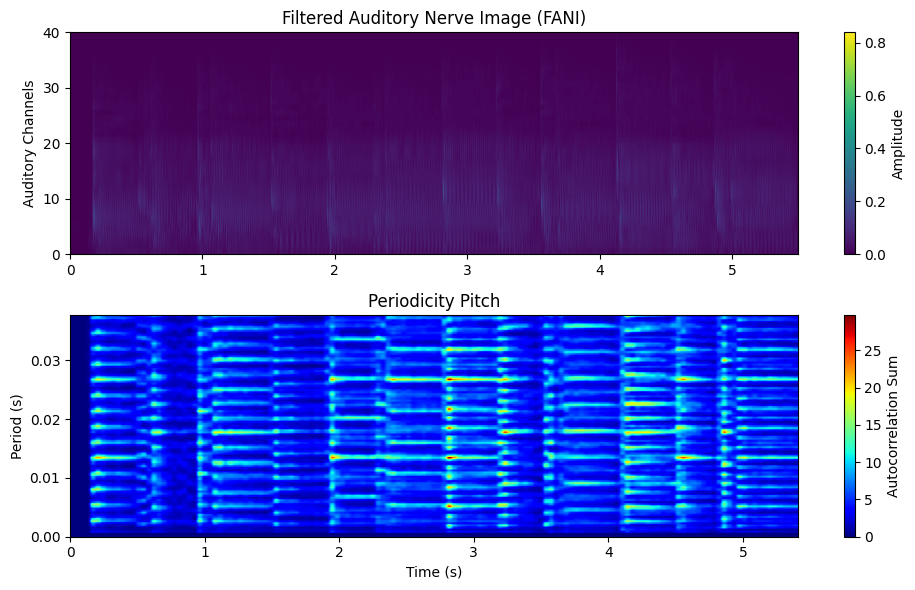

In [13]:
pp, out_fs, out_periods, fani, delay = calc_pp(ani, ani_freq)
final_pp = apply_attenuation(pp, atten_type='ipem_squash_hf')
plot_pp_results(fani, ani_freq, final_pp, out_fs, out_periods)

In [14]:
print(pp.shape)

(105, 143)


# 4. Leaky Integration and Context image(CI)

In [15]:
# leakyintegration
def leaky_integrate(out_signal, out_sample_freq, half_decay_time=0.1, enlargement=0.0):
    """
    Leaky Integration for context image

    Parameters:
        out_signal (ndarray): Periodicity Pitch (period_bins, frames)
        out_sample_freq (float): sample frequency of periodicity pitch representation
        half_decay_time (float): time (s) for amplitude to decay to half
        enlargement (float): time (s) to extend with zeros (if -1, use 2 * half_decay_time)

    Returns:
        out_li (ndarray): leaky integrated image
    """

    # Handle enlargement
    if enlargement == -1:
        enlargement = 2 * half_decay_time
    enlarge_samples = int(round(out_sample_freq * enlargement))

    # Calculate the integrator coefficient based on the half-decay time
    if half_decay_time != 0:
        integrator = 2 ** (-1.0 / (out_sample_freq * half_decay_time))
    else:
        integrator = 0.0

    # Create the input matrix by padding with zeros
    M = np.hstack([out_signal, np.zeros((out_signal.shape[0], enlarge_samples))])
    out_li = np.zeros_like(M)

    # Loop through the remaining time steps
    out_li[:, 0] = M[:, 0]
    for j in range(1, M.shape[1]):
        out_li[:, j] = integrator * out_li[:, j - 1] + M[:, j]

    return out_li

In [16]:
li = leaky_integrate(final_pp, out_fs, half_decay_time=0.1)

In [17]:
print(li)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.48918685e-02 5.76088887e-02 4.82536840e-02 ... 8.87216001e+00
  8.51464606e+00 8.01620262e+00]
 ...
 [1.12740795e-02 1.65885895e-02 1.81911461e-02 ... 2.40955487e+01
  2.31983910e+01 2.22953134e+01]
 [8.94195716e-03 1.18444800e-02 1.31487757e-02 ... 2.43919736e+01
  2.32685189e+01 2.14000516e+01]
 [6.41572414e-03 7.77672999e-03 1.06872363e-02 ... 1.56531294e+01
  1.48945488e+01 1.31711928e+01]]


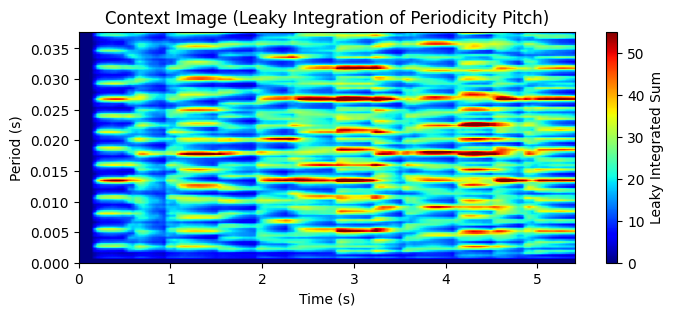

In [18]:
time = np.arange(li.shape[1]) / out_fs  # seconds
period = out_periods  # seconds (from calc_pp)
vmin = np.percentile(li, 0.1)
vmax = np.percentile(li, 99) 

plt.figure(figsize=(8, 3))
plt.imshow(
    li, 
    aspect='auto', 
    origin='lower',
    extent=[time[0], time[-1], period[0], period[-1]],
    cmap='jet',
    vmin=vmin,
    vmax=vmax
)
plt.colorbar(label='Leaky Integrated Sum')
plt.xlabel("Time (s)")
plt.ylabel("Period (s)")
plt.title("Context Image (Leaky Integration of Periodicity Pitch)")
plt.show()

In [19]:
print(li.shape)

(105, 143)


# 5. Tonal Space (TS)

In [20]:
# Loading SOM.mat file
import numpy as np
from scipy.io import loadmat

def load_som(som_path: str):
    """Read SOM.mat file containing sM and return (weights, msize)."""
    mat = loadmat(som_path, squeeze_me=True, struct_as_record=False)
    if "sM" not in mat:
        raise ValueError(f"There is no 'sM' in {som_path}.keys={list(mat.keys())}")
    sM = mat["sM"]

    # take codebook（n_units, n_features）
    weights = getattr(sM, "codebook", None)
    if weights is None:
        raise ValueError("SOM file is missing 'sM.codebook'.")
    weights = np.asarray(weights)

    # take topological size msize (rows, cols)
    topol = getattr(sM, "topol", None)
    if topol is None:
        raise ValueError("SOM file is missing 'sM.topol'.")
    msize = getattr(topol, "msize", None)
    if msize is None:
        try:
            msize = topol["msize"]
        except Exception as e:
            raise ValueError("SOM file is missing 'sM.topol.msize'.") from e
    msize = tuple(np.array(msize, dtype=int).ravel())

    return weights, msize


In [21]:
som_path = "C:/Users/w1881/Desktop/github/jlmt_python/map/map_10-Dec-2006_16_18.mat"

weights, msize = load_som(som_path)
print("weights shape (n_units, n_features):", weights.shape)
print("msize (rows, cols):", msize)
print("rows*cols == n_units ? ->", (msize[0] * msize[1] == weights.shape[0]))

weights shape (n_units, n_features): (768, 105)
msize (rows, cols): (np.int64(24), np.int64(32))
rows*cols == n_units ? -> True


In [22]:
import numpy as np

def calc_tonal_space(li, weights, msize):
    """
    Projects li images into Tonal Space using the SOM weight matrix.
   
    Parameters:
        li (np.ndarray): Leaky-integrated images of shape (n_features, n_frames)
        weights (np.ndarray): SOM weight matrix of shape (n_units, n_features).
        msize (tuple): Topology of the SOM grid given as (rows, cols).

    Returns:
        ts_activation_map_3d (np.ndarray): 3D Tonal Space activation map of shape (rows, cols, n_frames)
        ts_activation_map_2d (np.ndarray): 2D Tonal Space activation map of shape (n_units, n_frames)
    """
    print(f"Computing Tonal Space projection...")
    
    n_features_li, n_frames = li.shape
    n_units, n_features_weights = weights.shape

    if n_features_li != n_features_weights:
        raise ValueError(
            f"Feature dimension mismatch: LI has {n_features_li} features, "
            f"SOM weights have {n_features_weights}."
        )

    # 1. Normalization
    
    # Sum over each time frame (column)
    column_sums = li.sum(axis=0, keepdims=True)
    
    # Normalize each column; avoid division by zero using np.divide 'where'
    limg_norm = np.divide(li, column_sums, out=np.zeros_like(li), where=column_sums!=0)

    # 2. Projection onto SOM
    ts_activation_map_2d = weights @ limg_norm

    # 3. Reshape into 3D map (
    rows, cols = msize
    n_frames_act = ts_activation_map_2d.shape[1] 
    
    ts_activation_map_3d = ts_activation_map_2d.reshape((rows, cols, n_frames_act), order='F')
    
    print(f"...Done. TS activation map shape: {ts_activation_map_3d.shape}")
    
    return ts_activation_map_3d, ts_activation_map_2d

In [23]:
ts_map_3d, ts_map_2d = calc_tonal_space(li, weights, msize)

print(f"3D TS Map shape: {ts_map_3d.shape}")
print(f"2D TS Map shape: {ts_map_2d.shape}")

Computing Tonal Space projection...
...Done. TS activation map shape: (24, 32, 143)
3D TS Map shape: (24, 32, 143)
2D TS Map shape: (768, 143)


In [24]:
#Export ts_map_3d
import pandas as pd
import numpy as np

output_excel_file_3d = 'tonal_space_map_3d_sheets.xlsx'

with pd.ExcelWriter(output_excel_file_3d, engine='openpyxl') as writer:
    for j in range(ts_map_3d.shape[2]): 
        
        frame_data = ts_map_3d[:, :, j]
        
        df_frame = pd.DataFrame(frame_data)
        
        df_frame.to_excel(writer, sheet_name=f'Frame_{j+1}')

print(f"\nSuccess! File has been saved as: {output_excel_file_3d}")


Success! File has been saved as: tonal_space_map_3d_sheets.xlsx


In [25]:
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl (38.9 MB)


Total frames: 143
Computed FPS: 25.00 (interval 40.0 ms)
Total animation duration: 5.72 seconds


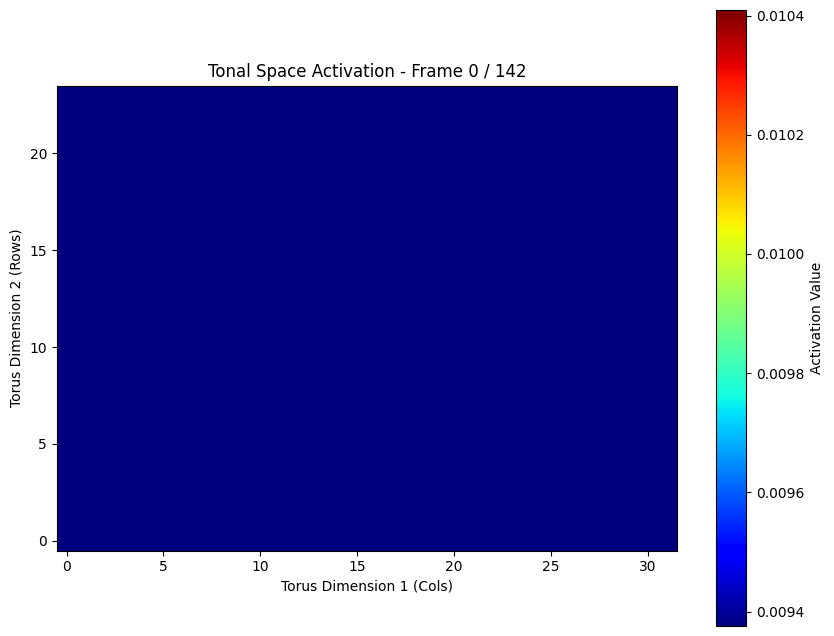

In [36]:
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# 1. Define real-time synchronization parameters
n_frames = ts_map_3d.shape[2] 
frame_step_sec = 0.04         
real_time_fps = 1.0 / frame_step_sec  
interval_ms = frame_step_sec * 1000 

print(f"Total frames: {n_frames}")
print(f"Computed FPS: {real_time_fps:.2f} (interval {interval_ms:.1f} ms)")
print(f"Total animation duration: {n_frames * frame_step_sec:.2f} seconds")

# 2. Prepare animation
rows, cols, _ = ts_map_3d.shape
vmin = np.percentile(ts_map_3d, 1)
vmax = np.percentile(ts_map_3d, 99)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(ts_map_3d[:, :, 0], cmap='jet', origin='lower', interpolation='bilinear', vmin=vmin, vmax=vmax)

cbar = fig.colorbar(im, ax=ax, label="Activation Value")
ax.set_title(f"Tonal Space Activation - Frame 0 / {n_frames-1}")
ax.set_xlabel("Torus Dimension 1 (Cols)")
ax.set_ylabel("Torus Dimension 2 (Rows)")

# 3. Update function for animation
def update(frame):
    im.set_data(ts_map_3d[:, :, frame])
    ax.set_title(f"Tonal Space Activation - Frame {frame} / {n_frames-1}")
    return (im,) 


In [37]:
import cv2
import numpy as np
output_filename = 'tonal_space_activation_CV2.mp4'
fps = real_time_fps
width = fig.canvas.get_width_height()[0]
height = fig.canvas.get_width_height()[1]

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

print(f"Starting to write {n_frames} frames using OpenCV...")


for frame_num in range(n_frames):
    update(frame_num) 
    fig.canvas.draw()

    img_buf = fig.canvas.buffer_rgba()
    img_array = np.frombuffer(img_buf, dtype=np.uint8).reshape((height, width, 4))

    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGBA2BGR)

    out.write(img_bgr)

    if frame_num % 100 == 0:
        print(f"Wrote frame {frame_num}...")

out.release()
plt.close(fig)
print(f"OpenCV animation saved as: {output_filename}")

Starting to write 143 frames using OpenCV...
Wrote frame 0...
Wrote frame 100...
OpenCV animation saved as: tonal_space_activation_CV2.mp4


In [ ]:
#pipeline
def run_pipeline(audio_path):
    y, sr = load_audio(audio_path)

    ani = calc_ani(y, sr)
    pp  = calc_pp(ani)
    li  = leaky_integrate(pp)
    ts  = calc_tonal_space(y, sr)

    return {"ANI": ani, "PP": pp, "LI": li, "TS": ts}